# Pre

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools as ft
from functools import reduce
import math
import networkx as nx
import networkx.classes.function as fn
import networkx.algorithms as alg
import multiprocessing
from joblib import Parallel, delayed
from copy import deepcopy
from scipy.stats import hypergeom
import random
from time import time
import multiprocessing
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
root = '/content/drive/MyDrive/Complex Network /RND/'

Mounted at /content/drive


In [ ]:
diesease_proteins = np.array(pd.read_csv(root+'bio-pathways-associations.csv')) 
disease_classes =  np.array(pd.read_csv(root+'bio-pathways-diseaseclasses.csv')) 
ppi_dataset = np.array(pd.read_csv(root+'bio-pathways-network.csv')) 

In [ ]:
### Incidence/Edge list of ppi network
ppi = np.array(ppi_dataset)
print("ith element of ppi:", ppi[0])

## Create a network from given edge list
G = nx.Graph()
G.add_edges_from(ppi)

## Nodes of network, Edges of Network
print("Total Nodes:",len(G.nodes()))
print("Total Edges:",len(G.edges()))

## Adjacancy Matrix In Networkx Format
n = nx.adjacency_matrix(G).shape
print("Shape of adjacency matrix:",n)

## Adjacancy List
adj = dict(G.adjacency())
print("Adjacency list of node_id = 1 : ",adj[1])

ith element of ppi: [1394 2778]
Total Nodes: 21557
Total Edges: 342353
Shape of adjacency matrix: (21557, 21557)
Adjacency list of node_id = 1 :  {1026: {}, 80854: {}, 10321: {}, 2886: {}, 6622: {}, 10549: {}, 6472: {}, 7083: {}, 310: {}, 368: {}, 6606: {}, 284161: {}}


In [ ]:
 ## Extract Largest Connected Component from the network

## Node lists of Connnected Components
cc_nodes = nx.connected_components(G)

## Nodes in Giant Component
gcc_nodes = max(cc_nodes, key=len)

## Giant component as subgraph of G
gcc = G.subgraph(gcc_nodes)

## Number of nodes and Number of edges
print("Nodes in GCC:",len(gcc.nodes()))
print("Edges in GCC:",len(gcc.edges()))

## Adjacancy Matrix (numpy array format)
gcc_adj_mat = nx.adjacency_matrix(gcc).todense()

### Adjacency list of Giant Connected Component (python dictionary format)
gcc_adj_list = dict(gcc.adjacency())

Nodes in GCC: 21521
Edges in GCC: 342316


In [ ]:
### Extract disease-wise protein data

## disease_proteins[disease_id] = list of seed proteins responsible for disease with disease_id.  
disease_proteins_list = {}

## total distinct proteins of disease related seeds (proteins) 
disease_seed_set = set()

for row in diesease_proteins:
  disease_id = row[0]
  disease_seeds  = [int(e) for e in row[2].replace(" ", "").split(',')]
  disease_proteins_list[disease_id] = disease_seeds 
  disease_seed_set.update (disease_seeds)

print("Total Number of Diseases:",len(disease_proteins_list))
print("Total Number of Diseases Proteins:",len(disease_seed_set))

Total Number of Diseases: 519
Total Number of Diseases Proteins: 7294


In [ ]:
### Remove disease proteins from pathway that are not in Giant component

## Set proteins which are related to any of the 519 diseases and belong to GCC of ppi network
seeds = set()

## pathway[disease_id] = list of seed proteins responsible for disease with disease_id and belong to GCC of ppi.  
pathway = {}

genes = set(gcc.nodes())
for id in disease_proteins_list:
  pathway[id] = [seed for seed in disease_proteins_list[id]  if seed in genes]
  seeds.update(pathway[id])  

order = list(pathway.keys())
nodes = list(gcc.nodes())

print("Number of nodes in Giant Component that are related to some disease: ", len(seeds))

Number of nodes in Giant Component that are related to some disease:  6289


In [ ]:
degs = list(dict(gcc.degree()).values())
print(len(degs))

s=0
for i in degs:
  for j in degs:
    s+= i*j
  s -= i*i

m = sum(degs)

Qmax = 1 - (s/(m*m))
Qmax

21521


0.00026168889900657355

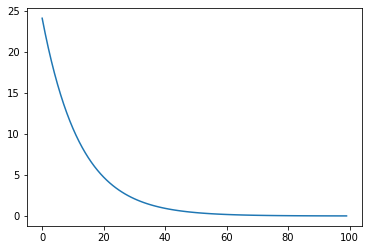

In [ ]:
Q = np.logspace(-2.2,-5.7,100)
plt.plot((Q/Qmax))

#Reduce

In [ ]:
## subgraphs for each disease

pathway_graph = {}

for id in pathway:
  pathway_graph[id] = gcc.subgraph(pathway[id]) 

In [ ]:
## maximum number of edges out of all disease subgraphs

mx=0
for id in pathway:
  mx = max(mx,len(pathway_graph[id].edges()))
mx

2018

In [ ]:
### Connected Component Subgraphs for each disease

pathway_cc = {}

for id in pathway:
 pathway_cc[id] = [gcc.subgraph(cc_nodes).copy() for cc_nodes in nx.connected_components(pathway_graph[id])]

#Disease characteristics connected components
worst_disease_id = max(pathway_cc,key=len)
cc_count = len(pathway_cc[worst_disease_id])
print("Disease with maximum number of connected components is: " , worst_disease_id, " with components = " , cc_count)

disease_cc_count = [len(pathway_cc[id]) for id in pathway]
print("Average number of connected components per disease: ", sum(disease_cc_count)/ len(disease_cc_count))

Disease with maximum number of connected components is:  C0036095  with components =  37
Average number of connected components per disease:  21.68208092485549


In [ ]:
### Node with maximum betweenness_centrality FOR each connected component FOR each Disease

pathway_cc_max_BC_node = {}

for id in pathway:
  pathway_cc_max_BC_node[id] = []
  for cc in pathway_cc[id]:
    bc = dict(alg.centrality.betweenness_centrality(cc))
    cc_nodes = list(bc.keys())
    cc_bc_values = list(bc.values())
    max_bc_node = cc_nodes[cc_bc_values.index(max(cc_bc_values))]
    pathway_cc_max_BC_node[id].append(max_bc_node)

In [ ]:
## keep only disease pathways and the nodes connecting the pathway components
## Add shortest paths between components using max BetweenNess Centrality Nodes
keep = set()
  
for id in pathway: 
  keep.update(pathway[id])
  n = len(pathway_cc[id])
  for i in range(n):
    for j in range(i+1,n):
      path = alg.shortest_paths.generic.shortest_path(G,pathway_cc_max_BC_node[id][i],pathway_cc_max_BC_node[id][j])
      if len(path)>1: keep.update(path)

### Add Edges in Each Disease Each Connected Component
gcc_reduced = gcc.subgraph(keep)

## Number of nodes and Number of edges in reduced graph
print("Nodes in Reduced Graph:",len(gcc_reduced.nodes()))
print("Edges in Reduced Graph:",len(gcc_reduced.edges()))

Nodes in Reduced Graph: 11630
Edges in Reduced Graph: 284013


In [ ]:
## All pair shortest paths for reduced disease network
p = nx.shortest_path_length(gcc_reduced) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


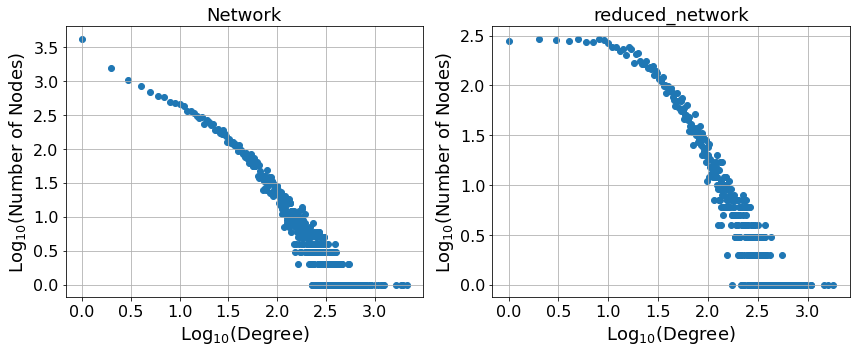

In [ ]:
## Degree Histogram 
def plot_hist(graph, name = 'Network'):
  degree_histogram = fn.degree_histogram(graph)[1:] #list with i th index as frequency of degree = i
  sz = len(degree_histogram)
  x = np.linspace(1,sz,sz)
  
  plt.scatter(np.log10(x[:sz]),np.log10(degree_histogram[:sz]))
  plt.title(name, fontsize = 18)
  plt.xlabel("Log$_{10}$(Degree)", fontsize = 18)
  plt.ylabel("Log$_{10}$(Number of Nodes)", fontsize = 18)
  plt.grid()
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.tight_layout()

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plot_hist(gcc)
plt.subplot(1,2,2)
plot_hist(gcc_reduced, 'reduced_network')
plt.show()

#Characterization

In [ ]:
### Disease Subgraph Characterizations
def pathway_characterization(disease_id):
    disease_properties = {}

    total_nodes = list(gcc.nodes())
    adjacency_matrix = gcc_adj_mat.copy()
    n = adjacency_matrix.shape[0]

    disease_nodes = pathway[disease_id]
    disease_indices = np.sort([total_nodes.index(seed) for seed in disease_nodes])

    num_total_nodes = adjacency_matrix.shape[0]
    num_total_edges = np.sum(adjacency_matrix)/2

    num_nodes = len(disease_indices)
    disease_properties["num_nodes"] = num_nodes

    subgraph = gcc.subgraph(disease_nodes)
    sliced_adj_matrix = adjacency_matrix[disease_indices, :]
    num_disease_node_edges = np.sum(sliced_adj_matrix)/2
    sub_adj_matrix = sliced_adj_matrix[:, disease_indices]
    num_internal_edges = np.sum(sub_adj_matrix)/2
    external_edges = num_disease_node_edges - num_internal_edges
    
    #Internal connectivity
    disease_properties["density"] = nx.density(subgraph)
    disease_properties["average_degree"] = 2*num_internal_edges/num_nodes
    disease_properties["average_internal_clustering"] = nx.average_clustering(subgraph)

    conn_comps = nx.connected_components(subgraph)
    sorted_cc = [len(c) for c in sorted(conn_comps, key=len, reverse=True)]
    disease_properties["size_largest_connected_component"] = sorted_cc[0]
    disease_properties["percent_in_largest_connected_component"] = float(sorted_cc[0])/num_nodes
    disease_properties["number_connected_components"] = len(sorted_cc)

    #External connectivity
    disease_properties["expansion"] = external_edges/num_nodes
    disease_properties["cut_ratio"] = external_edges/(num_nodes*(num_total_nodes-num_nodes))

    #External and internal connectivity
    disease_properties["conductance"] = external_edges/(2*num_internal_edges+external_edges)
    disease_properties["normalized_cut"] = disease_properties["conductance"] + external_edges/(2*(num_total_edges-num_internal_edges)+external_edges)

    return disease_properties

In [ ]:
pathway_characteristics = {}
for id in pathway:
  pathway_characteristics[id] = pathway_characterization(id)

In [ ]:
id = order[0]
row_order = list(pathway_characteristics[id].keys())

data = np.array([ [pathway_characteristics[id][key] for key in row_order] for id in order])

df = pd.DataFrame(data=data, index=order, columns=row_order)
df.to_csv("pathway_characteristics.csv")

In [ ]:
# def property(p, bin = 20):
#   all_disease_property_p = [pathway_characteristics[id][p] for id in pathway]
#   plt.hist(all_disease_property_p, bins=bin, edgecolor='black', linewidth=1.2)
#   plt.title(p)
#   plt.show()

# property('density')
# property('average_internal_clustering')

In [ ]:
!git clone https://github.com/mims-harvard/pathways

fatal: destination path 'pathways' already exists and is not an empty directory.


#Shuffle for Kfold Disease Indices

In [ ]:
## Shuffler[id] = shuffled indices of nodes in disease with given id.

shuffler = {}

np.random.seed(1)
for id in pathway:
  shuffler[id] = [nodes.index(seed) for seed in pathway[id]]
  np.random.shuffle(shuffler[id])

#Recall at k

In [ ]:
#  recall at k
#  true positives in top k scores

def  recall_k(score, true, k = 100):
  pairs = [(p[1],p[0]) for p in list(enumerate(score))]
  pairs = sorted(pairs,reverse= True)[:k]
  c = 0
  for p in pairs:
    c += p[1] in true
  return c/len(true)

# Diamond

In [ ]:
#%pycat /content/pathways/prediction/diamond.py


# Implementation of the DIAMOnD method from Ghiassian et al


# Avoids doing the costly hypergeometric calculation if the result will definitely be lower than an existing candidate
def _compare_to_existing(processed_list, seed_conns, total_conns):
    less_likely = [(a, b) for (a,b) in processed_list if a>=seed_conns and b<=total_conns]
    if len(less_likely) == 0: 
        return False
    return True

""" Returns list of scores, based on using assoc_gene_vector as the initial vector, for top number_to_rank predictions.

Inputs:
adjacency_matrix: Unnormalized adjacency matrix of shape (number_genes, number_genes)
assoc_gene_vector: Numpy array of shape (number_genes,) with 1's for seed proteins, and 0's elsewhere
alpha: The weight given to seeds
number_to_rank: The number of iterations to run DIAMOnD
"""
def diamond_scores(adjacency_matrix, assoc_gene_vector, alpha=5, number_to_rank=100):
    num_genes = assoc_gene_vector.shape[0]
    edges_per_gene = np.sum(adjacency_matrix, axis=0)
    scores = np.zeros(assoc_gene_vector.shape)
    seeds = np.copy(assoc_gene_vector)
    connections_to_seeds = np.sum(adjacency_matrix[:, np.nonzero(assoc_gene_vector)[0]], axis = 1)
    num_gene_edges = edges_per_gene + (alpha-1)*connections_to_seeds.T
    N = num_genes + np.sum(assoc_gene_vector)*(alpha-1)
    connections_to_seeds = connections_to_seeds * (alpha)
    num_seeds = alpha*np.sum(assoc_gene_vector)
    for index in range(1, number_to_rank+1):
        potential_cand = np.nonzero(connections_to_seeds*(1-seeds)>=1)[0]
        num_candidates = potential_cand.shape[0]
        if num_candidates == 0: break
        best_cand = -1
        best_conn = 1
        existing_calculations = []
        for i in range(num_candidates):
            cand_index = potential_cand[i]
            #print(list(connections_to_seeds.T)[0],list(num_gene_edges)[0])
            if _compare_to_existing(existing_calculations, (connections_to_seeds.T).tolist()[0][cand_index], (num_gene_edges).tolist()[0][cand_index]):
                continue
            conn = hypergeom.sf((connections_to_seeds.T).tolist()[0][cand_index]-1, N, num_seeds, (num_gene_edges).tolist()[0][cand_index])
            existing_calculations.append(((connections_to_seeds.T).tolist()[0][cand_index], (num_gene_edges).tolist()[0][cand_index]))
            if conn < best_conn:
                best_conn = conn
                best_cand = cand_index
        connections_to_seeds += adjacency_matrix[:, best_cand]
        seeds[best_cand] = 1
        scores[best_cand] = 1.0/index
        num_seeds += 1
    return scores


kfold = {}
c=0
for id in pathway:
  total_nodes = list(gcc.nodes())
  nn = len(gcc.nodes())
  disease_nodes = pathway[id]
  n = len(pathway[id])
  disease_indices = random.sample([total_nodes.index(seed) for seed in disease_nodes],9*n//10)
  assoc = np.zeros(nn)
  for i in range(nn):
    assoc[i] =  i in disease_indices
  score = diamond_scores(gcc_adj_mat, assoc, alpha=5, number_to_rank=100)
  break

In [ ]:
kfold = {}
c=0
for id in pathway:
  total_nodes = list(gcc.nodes())
  nn = len(gcc.nodes())
  disease_nodes = pathway[id]
  n = len(pathway[id])
  disease_indices = random.sample([total_nodes.index(seed) for seed in disease_nodes],9*n//10)
  assoc = np.zeros(nn)
  for i in range(nn):
    assoc[i] =  i in disease_indices
  score = diamond_scores(gcc_adj_mat, assoc, alpha=5, number_to_rank=100)
  break

UnboundLocalError: ignored

#Neighbourhood Done

In [ ]:
def neighborhood_scores(adjacency_matrix, disease_indices):

  n = adjacency_matrix.shape[0]
  total_neighbors = np.sum(adjacency_matrix, axis = 1)

  assoc_diseases = adjacency_matrix[:, disease_indices]
  assoc_neighbors = np.sum(assoc_diseases, axis = 1)

  assoc_gene_vector = np.zeros(n)
  assoc_gene_vector[disease_indices] = 1
  assoc_gene_vector = np.reshape(assoc_gene_vector,(n,1))

  scores = assoc_neighbors/(total_neighbors + (1e-7))
  scores = np.multiply(scores , (1 - assoc_gene_vector))
  return scores

start = 0
end = len(order)
k = 10
for id in order[start:end]:
  recall = 0
  n = len(pathway[id])
  step = int(n/k)
  for i in range(k):
    st = i*step
    en = min((i+1)*step,n) 
    nn = en - st
    if nn<=0: continue
    kf = shuffler[id][:st] + shuffler[id][en:]
    of = shuffler[id][st:en]
    score = neighborhood_scores(gcc_adj_mat, kf)
    recall += recall_k(score,of)
  recall_100_neighbourhood[id] = recall/k

In [ ]:
data = np.array([recall_100_neighbourhood[id] for id in order[start:end]])
data = np.reshape(data, (end-start,1))
df = pd.DataFrame(data=data,index=order[start:end])
df.to_csv("neighborhood_recall_scores.csv")

#random walk

In [ ]:
def random_walk_scores(adjacency_matrix, disease_indices, return_prob= 0.75):
	
  n = adjacency_matrix.shape[0]
  assoc_gene_vector = np.zeros(n)
  assoc_gene_vector[disease_indices] = 1
  assoc_gene_vector = np.reshape(assoc_gene_vector,(n,1))

  ratio = return_prob
  convergence_metric = 1
  p0 = assoc_gene_vector/np.sum(assoc_gene_vector)
  old_vector = p0.copy()
  while (convergence_metric>1e-3):
    new_vector = (1-ratio) * np.matmul(adjacency_matrix, old_vector) + ratio * p0
    new_vector = new_vector/np.linalg.norm(new_vector,1)
    convergence_metric = np.linalg.norm(new_vector-old_vector)
    old_vector = np.copy(new_vector)
  scores = np.multiply(old_vector , (1 - assoc_gene_vector))
  return scores

scores = {}
st= time()
c=0
for id in pathway:
  scores[id] = random_walk_scores(gcc_adj_mat, kfold[id])
  c+=1
  print('\r',c,end='')
print('')
en = time()
t = (en-st)/60
print('Time taken for all diseases:',t)

In [ ]:
data = np.array([np.reshape(scores[id],21521).tolist()[0] for id in order])
df = pd.DataFrame(data=data,index=order,columns=nodes)
df.to_csv("random_walk_scores.csv")

#Recall vs Density

In [ ]:
df = pd.read_csv(root+'pathway_characteristics.csv')
df.keys() 

Index(['Unnamed: 0', 'num_nodes', 'density', 'average_degree',
       'average_internal_clustering', 'size_largest_connected_component',
       'percent_in_largest_connected_component', 'number_connected_components',
       'expansion', 'cut_ratio', 'conductance', 'normalized_cut'],
      dtype='object')

In [ ]:
y_vals = []

for i in range(26):
  k = i*20
  d1 = pd.read_csv(root+"/random walk/"+'random_walk_recall_scores_{}.csv'.format(k))
  d1 = np.array(d1['0']).tolist()
  y_vals += d1

y = np.array(y_vals)
y.shape

(519,)

In [ ]:
char = 'average_internal_clustering'
x = df[char]
# y = []
# for id in pathway:
#    y += [recall_100_neighbourhood[id]]

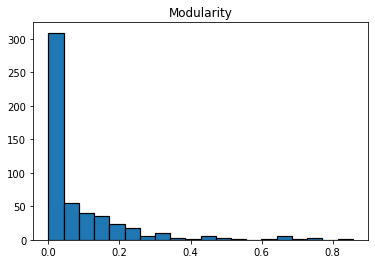

In [ ]:
#plt.scatter(x,y,s=10)
#plt.scatter(x,y,s=10)

#plt.xlim((0,1))
#plt.ylim((0,1))

plt.hist(x, bins=20, edgecolor='black', linewidth=1.2)
plt.title('Modularity')
plt.show()

In [ ]:
## => Avg Distance for each disease

In [ ]:
char = 'density'
x = df[char]
# y = []
# for id in pathway:
#   y += [recall_100_neighbourhood[id]]

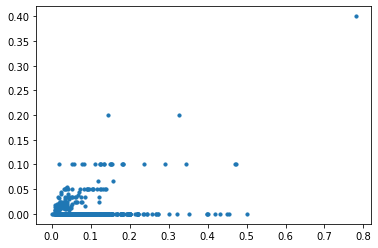

In [ ]:
plt.scatter(x,y,s=10)
#plt.scatter(x,y,s=10)

#plt.xlim((0,1))
#plt.ylim((0,1))